# Лабораторная работа 5
Градиентный бустинг с Catboost

Выполнил: 6133-010402D, Богданова Юлия Николаевна

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import catboost
print(catboost.__version__)

1.0.6


0 Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.

## Dataset Description

Source: https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation  
Type: Multiclass  

Customer segmentation is the practice of dividing a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits.  

|#|Attribute name|Attribute Information| Usage in model|
| :-: | :- | -: |:-|
|1|ID| Unique id (category)| not used |
|2|Gender|Gender (Binary) | used as 0/1|
|3|Ever_Married| Marital status of the customer (Binary)| used as 0/1 |
|4|Age| Customer Age (numerical)| used as it is |
|5|Graduated| Is the customer a graduate (Binary)|used as 0/1|
|6|Profession| Profession (Categorical)|used as dummies|
|7|Work_Experience| Work Experience in years (Numerical)|used as it is|
|8|Spending_Score| Spending score (Category)| used as it is |
|9|Family_Size| Amount of members in family (Numerical)|used as it is|  
|10|Var_1	| Anonymised Category for the customer (category)|used as dummies|  
|11| __Target__: Segmentation| 4 segments (A, B, C, D )|used as it is|

In [131]:
data_df = pd.read_csv("./datasets/customer_multi_train.csv")

In [132]:
data_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


<AxesSubplot:>

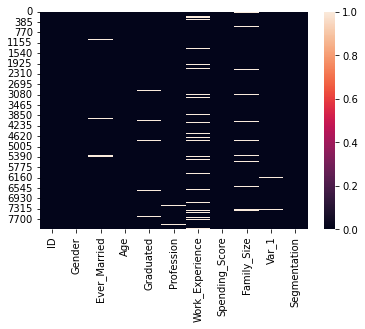

In [5]:
# There are some nullvalues
sns.heatmap(data_df.isnull())

In [133]:
data_df.dropna(axis=0, subset=['Gender','Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1'], inplace=True)

Dataset size =  6665


<AxesSubplot:>

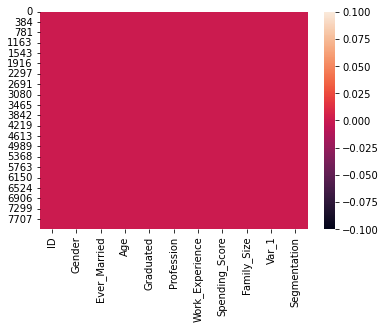

In [134]:
print('Dataset size = ', len(data_df))
sns.heatmap(data_df.isnull())

D    1757
C    1720
A    1616
B    1572
Name: Segmentation, dtype: int64


[Text(0.5, 1.0, 'Countplot of target')]

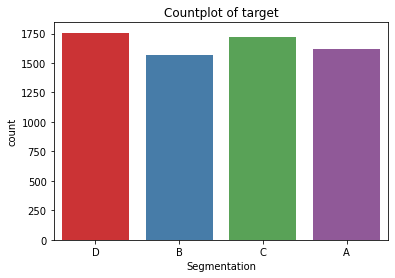

In [8]:
# classes are well balanced
print(data_df['Segmentation'].value_counts())
sns.countplot(x = data_df['Segmentation'], data = data_df, palette='Set1').set(title='Countplot of target')

In [135]:
del data_df['ID']

In [10]:
data_df[:2]

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


## 1 Применить классификатор CatBoostClassifier к вашему набору данных. 
Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.

- Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
- Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).
- В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

In [13]:
from sklearn.model_selection import train_test_split

In [136]:
# Split Targets and Features
y = data_df['Segmentation']
X = data_df.drop(['Segmentation'], axis=1)

In [137]:
# Tell catboost wich features are categorical
cat_features = list(range(0, X.shape[1]))
# remove numerical
cat_features.remove(data_df.columns.get_loc("Age"))
cat_features.remove(data_df.columns.get_loc("Work_Experience"))
cat_features.remove(data_df.columns.get_loc("Family_Size"))
cat_features

[0, 1, 3, 4, 6, 8]

In [20]:
pool1 = catboost.Pool(data=X, label=y, cat_features=cat_features)
print(pool1.shape)
print(pool1.get_feature_names())

(6665, 9)
['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [47]:
params = {
    'iterations' : 40,
    'random_seed' : 63,
    'learning_rate' : 0.5,
    'custom_loss' : ['AUC', 'Accuracy'],
    'loss_function' : 'MultiClass'
    
}

cv_data = catboost.cv(
    params=params,
    pool = pool1,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.036854897
bestIteration = 24

Training on fold [1/5]

bestTest = 1.047731544
bestIteration = 30

Training on fold [2/5]

bestTest = 1.071269223
bestIteration = 13

Training on fold [3/5]

bestTest = 1.029502656
bestIteration = 23

Training on fold [4/5]

bestTest = 1.040892732
bestIteration = 28



In [49]:
model.get_best_iteration()

37

In [76]:
print('Best scores for test dataset: ')
model.best_score_['validation']

Best scores for test dataset: 


{'Precision:class=3': 0.6615384615384615,
 'Recall:class=3': 0.7129840546697038,
 'Recall:class=0': 0.5322997416020672,
 'Recall:class=2': 0.6855345911949685,
 'Precision:class=1': 0.37817258883248733,
 'Precision:class=2': 0.6565420560747663,
 'Precision:class=0': 0.47685185185185186,
 'Recall:class=1': 0.41208791208791207,
 'AUC:type=Mu': 0.8283997133348651,
 'MultiClass': 1.0360481742417542,
 'Accuracy': 0.5500899820035993}

В предыдущей лабораторной для этого же датасета был использован классификатор kNN, он дал accuracy=0.50. Catboost совсем немного лучше.

In [78]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Profession,23.955584
1,Age,23.277247
2,Spending_Score,18.658215
3,Family_Size,12.356965
4,Graduated,8.702777
5,Var_1,4.363936
6,Gender,3.500681
7,Work_Experience,2.888965
8,Ever_Married,2.295629


## 2 Применить регрессию CatBoostRegressor к набору данных для регрессии. 
Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [139]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data_df['Segmentation'])
print(le.classes_)
data_df['Segmentation'] = le.transform(data_df['Segmentation'])
print(data_df['Segmentation'].unique())

['A' 'B' 'C' 'D']
[3 1 2 0]


In [145]:
data_df[:2]

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,3
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,1


In [147]:
# Make it binary by leaving only two classes with the most samples amount
data_df = data_df.drop(data_df[data_df['Segmentation'] == 0].index)
data_df = data_df.drop(data_df[data_df['Segmentation'] == 1].index)

In [151]:
print(data_df['Segmentation'].value_counts())

3    1757
2    1720
Name: Segmentation, dtype: int64


In [153]:
# Split Targets and Features
y = data_df['Segmentation']
X = data_df.drop(['Segmentation'], axis=1)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [156]:
model = catboost.CatBoostRegressor(
    iterations=50,
    learning_rate=0.5,
    loss_function='RMSE',
    early_stopping_rounds=5
)

model.fit(X_train, y_train,
          cat_features=cat_features,
          eval_set=(X_test, y_test),
          verbose=False,
          plot=True
)

print('Model is fitted: ', model.is_fitted())
print('Best iteration: ', model.get_best_iteration())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted:  True
Best iteration:  21


In [158]:
print('Best scores for test dataset: \n', model.best_score_['validation'])
print('MSE: ', mean_squared_error(y_test, model.predict(data=X_test)))

Best scores for test dataset: 
 {'RMSE': 0.32411851946352915}
MSE:  0.10505281465923001


In [162]:
model = catboost.CatBoostRegressor(
    iterations=50,
    learning_rate=0.5,
    loss_function='MAE',
    early_stopping_rounds=5
)

model.fit(X_train, y_train,
          cat_features=cat_features,
          eval_set=(X_test, y_test),
          verbose=False,
          plot=True
)

print('Model is fitted: ', model.is_fitted())
print('Best iteration: ', model.get_best_iteration())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted:  True
Best iteration:  8


In [165]:
print('Best scores for test dataset: \n', model.best_score_['validation'])
print('MAE: ', mean_absolute_error(y_test, model.predict(data=X_test)))

Best scores for test dataset: 
 {'MAE': 0.17992047072548384}
MAE:  0.17992142773461559
